<a href="https://colab.research.google.com/github/CPernet/OpenNeuro_MetaPrivAssessment/blob/main/TheDallasLifespanBrainStudy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries

# Link to the repo and import local data and library

In [1]:
# Import Libraries
!git clone https://github.com/CPernet/OpenNeuro_MetaPrivAssessment.git

import sys
sys.path.append("..")
import os
os.chdir('OpenNeuro_MetaPrivAssessment') # Change directory to the cloned repository

Cloning into 'OpenNeuro_MetaPrivAssessment'...
remote: Enumerating objects: 186, done.
remote: Counting objects: 100% (186/186), done.
remote: Compressing objects: 100% (165/165), done.
remote: Total 186 (delta 69), reused 97 (delta 18), pack-reused 0 (from 0)
Receiving objects: 100% (186/186), 3.88 MiB | 12.52 MiB/s, done.
Resolving deltas: 100% (69/69), done.


In [2]:
%%bash
set -e
sudo apt-get update -qq
sudo DEBIAN_FRONTEND=noninteractive \
     apt-get install -qq -y --no-install-recommends r-base r-base-dev

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [3]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import spearmanr, kendalltau, linregress
import warnings
warnings.filterwarnings('ignore')
!pip install piflib
import logging
logging.getLogger('rpy2.rinterface_lib.callbacks').setLevel(logging.ERROR)
!pip install -q rpy2
import metaprivBIDS_stat as ST
from metaprivBIDS_stat import plot_calc
from metaprivBIDS_stat import rst_outlier_case2

## Import result files from metaprivBIDS App analysis
DALLAS is the raw dataset "The Dallas Lifespan Brain Study".


In [5]:
DALLAS = 'https://s3.amazonaws.com/openneuro.org/ds004856/participants.tsv?versionId=IwNXA1rR0LIzEtfMB3kPETHQpZzbovbu'
DALLAS = pd.read_csv(DALLAS, sep='\t')
DALLAS.to_csv('TheDallasLifespanBrainStudy/data_ds004856/DALLAS_dataset_ds003097.csv', sep=',', index=False)

# Load in of results calculated using (MetaprivBIDS App)

In [8]:
suda = pd.read_csv('TheDallasLifespanBrainStudy/data_ds004856/suda_ds004856.csv', sep=',')
pif = pd.read_csv('TheDallasLifespanBrainStudy/data_ds004856/pif_df004856.csv', sep=',',index_col='Unnamed: 0').sort_index()
suda_field_score =  pd.read_csv('TheDallasLifespanBrainStudy/data_ds004856/att_suda.csv', sep=',').drop(columns=['Unnamed: 0'], errors='ignore')
k_combined_field =  pd.read_csv('TheDallasLifespanBrainStudy/data_ds004856/normalized_difference_dallas.csv', sep=',').drop(columns=['Difference in Unique Rows','Unique Rows After Removal']).rename(columns={'Column': 'variable'})
k_combined_all = pd.read_csv('TheDallasLifespanBrainStudy/data_ds004856/k-combined-3-to-11.csv', sep=',')
k_combined_field_non_risk = pd.read_csv('TheDallasLifespanBrainStudy/data_ds004856/non_normalized_difference_results.csv', sep=',').drop(columns=['Difference in Unique Rows','Unique Rows After Removal']).rename(columns={'Column': 'variable'})

The selected quasi identifers are:
- AgeCog_W1
- Height_W1
- HandednessScore
- EduYrsEstCap
- Race
- EduComp
- Sex
- Ethnicity

The selected sensitive variables are:
- Race & ethhnicity

# T-test between risky and non-risky k-global values for variables.


## Non risky variables

In [9]:
print(k_combined_field_non_risk)

        variable  Normalized Difference
0        MMSE_W3                    0.0
1        MMSE_W2                    0.0
2        MMSE_W1                    0.0
3      Height_W2                    0.0
4   AgePETTau_W2                    0.0
5         BMI_W1                    0.0
6         BMI_W2                    0.0
7      CogW1toW3                    0.0
8      CogW2toW3                    0.0
9      MRIW1toW3                    0.0
10     MRIW2toW3                    0.0
11     CogW1toW2                    0.0
12     MRIW1toW2                    0.0
13     Weight_W1                    0.0
14  PETAmyW1toW2                    0.0
15     Weight_W2                    0.0
16     AgeMRI_W1                    0.0
17     AgeMRI_W2                    0.0
18     AgeCog_W2                    0.0
19  PETAmyW2toW3                    0.0
20  PETAmyW1toW3                    0.0
21     AgeCog_W3                    0.0
22     AgeMRI_W3                    0.0
23  AgePETAmy_W1                    0.0


## Risky variables

In [10]:
print(k_combined_field)

          variable  Normalized Difference
0        AgeCog_W1                    1.6
1        Height_W1                    1.3
2  HandednessScore                    0.3
3     EduYrsEstCap                    0.0
4             Race                    0.0
5          EduComp                    0.0
6              Sex                    0.0
7        Ethnicity                    0.0


## Result of Paired T-test


In [11]:
mean_risk_values = (k_combined_field['Normalized Difference']).mean()
print('Mean, risk identifiers:',mean_risk_values)

Mean, risk identifiers: 0.4


In [12]:
mean_risk_values = (k_combined_field_non_risk['Normalized Difference']).mean()
print('Mean, non-risk identifiers:',mean_risk_values)

Mean, non-risk identifiers: 0.0


In [13]:
t, p = stats.ttest_ind(k_combined_field['Normalized Difference'], k_combined_field_non_risk['Normalized Difference'])
print('t:',t,'p-value:', p)

t: 3.2632406432560748 p-value: 0.002565193272726757


# PIF and SUDA Outliers


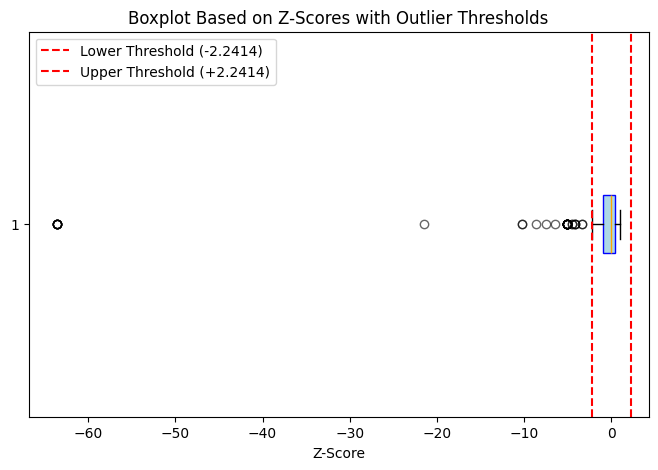

number of outliers found 0


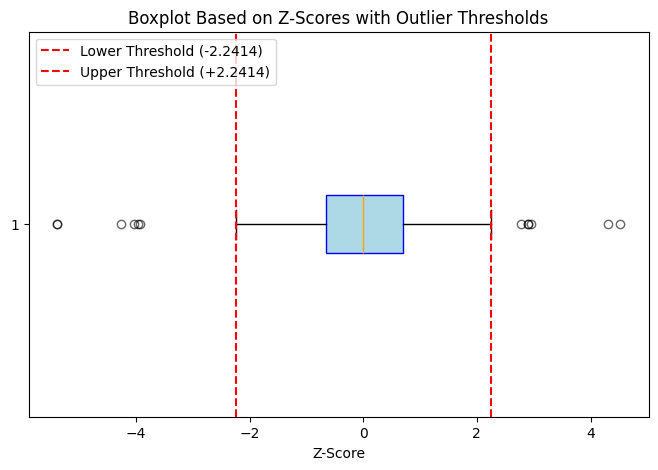

number of outliers found 14
Joint outlier indices: []


In [14]:
# SUDA outliers
results_suda = ST.rst_outlier_case2(suda, 'dis-score')
above_SUDAoutlier_indices = set(results_suda[4]) # Assuming the 4th element (index 3) is the list of outlier indices
print('number of outliers found',len(above_SUDAoutlier_indices))

#PIF outliers
results_pif = ST.rst_outlier_case2(pif, 'RIG')
above_PIFoutlier_indices = set(results_pif[4]) # Assuming the 4th element (index 3) is the list of outlier indices
print('number of outliers found',len(above_PIFoutlier_indices))

# Find the intersection of the two sets
joint_outlier_indices_set = above_SUDAoutlier_indices.intersection(above_PIFoutlier_indices)
joint_outlier_indices = list(joint_outlier_indices_set)
print("Joint outlier indices:", joint_outlier_indices)


## Outlier Participant  

In [15]:
column_names = [

    "participant_id",
    "AgeCog_W1",
    "Height_W1",
    "HandednessScore",
    "EduYrsEstCap",
    "Race",
    "EduComp",
    "Sex",
    "Ethnicity"
]
DALLAS[column_names].loc[58]

,58
participant_id,sub-1362
AgeCog_W1,54
Height_W1,61.0
HandednessScore,3.909
EduYrsEstCap,20.0
Race,3
EduComp,5.0
Sex,f
Ethnicity,1.0


## Correlation among privacy metrics.

MetaprivBIDS stats computes all correlations (Spearman, Pearson, Kendall) on the row level (i.e. how SUDA and PIF scores for each participants are correlated) and field level (i.e. how the SUDA field score, PIF Field Information Gain and K-global are correlated, at the variable level).


        ROW LEVEL CORRELATION      

Spearman Rank Correlation between suda & pif: 0.57, P-value: 0.0000
Kendall's Tau between suda & pif: 0.40, p-value: 0.0000
Pearson Correlation between suda & pif: 0.3306


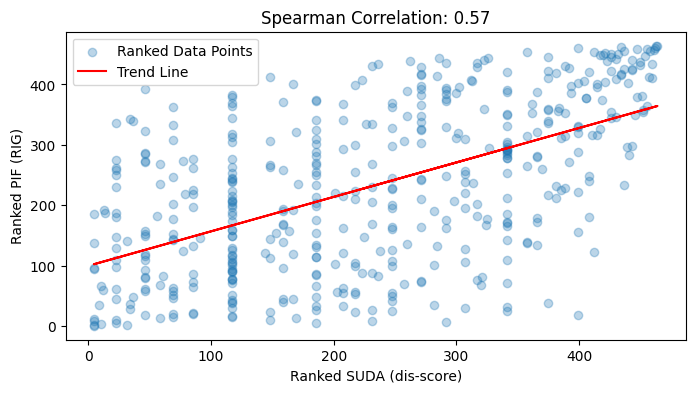

____________________________________________________________________________________

      FIELD LEVEL CORRELATIONS     

Pearson Correlation between SUDA & PIF field level: 0.83
Pearson Correlation between K-combined & PIF field level: 0.69
Pearson Correlation between SUDA & K-combined field level: 0.76


Spearman Rank Correlation between PIF & SUDA: 0.71, P-value: 0.0713
Spearman Rank Correlation between PIF & K: 0.80, P-value: 0.0301
Spearman Rank Correlation between SUDA & K: 0.40, P-value: 0.3728


In [16]:
ST.stats(suda, pif, suda_field_score, k_combined_field)

## Additional checks

We iterate through all possible combinations of variables & calculate the correlations between SUDA, K-Global and PIF. This analysis reveals, maybe, the true relationships between metrics independently of a particular variable.

In [17]:
sum_score_df  = ST.calculate_summed_dis_scores(k_combined_all, DALLAS, sample_fraction=0.3, missing_value= np.nan)

Spearman Correlation between Suda sum and K-combined: 0.73
Pearson Correlation between Suda sum and K-combined: 0.56


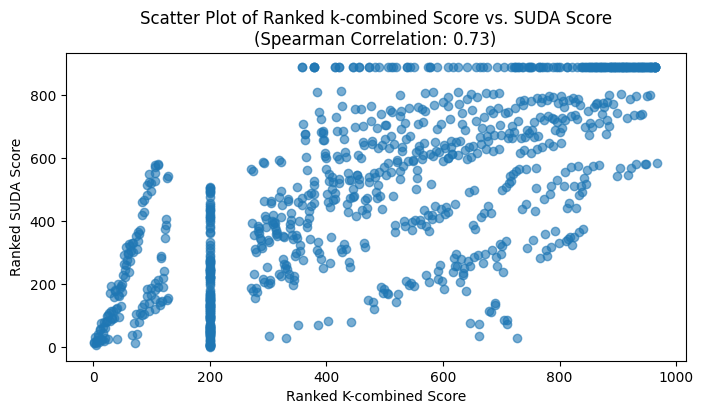

________________________________________________________________________


Spearman Correlation between PIF 95% and K-combined: 0.80
Pearson Correlation between PIF 95% and K-combined: 0.77


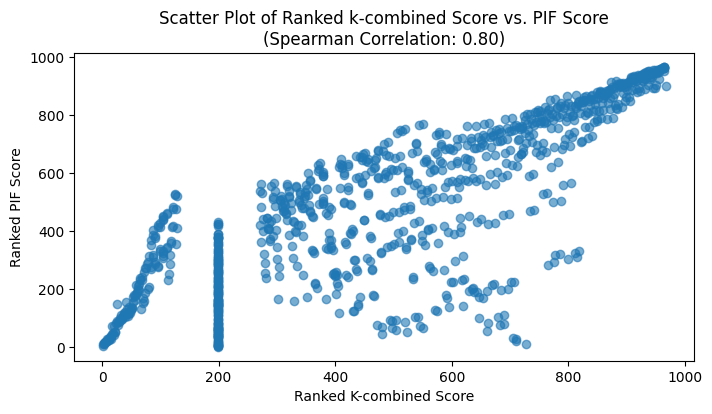

________________________________________________________________________


Spearman Correlation between PIF 95% and SUDA: 0.84
Pearson Correlation between PIF 95% and SUDA: 0.82


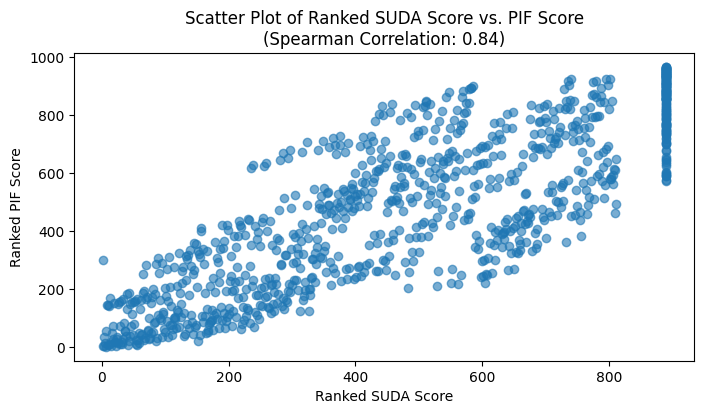

In [18]:
plot_calc(sum_score_df)